# PEtab extention for FitMultiCell 

In this example, we will show how a PEtab problem can be defined in FitMultiCell pipeline. For this, we will use a 1D activator-inhibitor model<sup>1</sup>. First, we will try to define the problem without the use of PEtab format.

## Regular FitMultiCell problem

At first, lets's import the required packages.

In [1]:
import petab_MS
from fitmulticell.PEtab.base import PetabImporter
from fitmulticell.model import MorpheusModel as morpheus_model
from fitmulticell.model import MorpheusModels as morpheus_models
from pyabc.sampler import RedisEvalParallelSampler
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc import QuantileEpsilon
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import pyabc
import matplotlib.pylab as plt
from pathlib import Path
import os
import tempfile

ABC.External ERROR: Install rpy2 to enable simple support for the R language.


Now, let's define the xpath for each parameter.

In [2]:
par_map = {'rho_a': './Global/System/Constant[@symbol="rho_a"]',
           'mu_i': './Global/System/Constant[@symbol="mu_i"]',
           'mu_a': './Global/System/Constant[@symbol="mu_a"]',
           }

Here, we define the ground truth value for each parameter which we used to generate the senthitic data.

In [3]:
obs_pars = {'rho_a': 0.01,
            'mu_i': 0.03,
            'mu_a': 0.02,
           }
obs_pars_log = {key: math.log10(val) for key, val in obs_pars.items()}


Next, we will import the senthitic data and give the path to Morpheus model.

In [4]:
condition1_obs = str((Path(os.getcwd())) / 'PEtab_problem_1' / 'Small.csv')

model_file = str((Path(os.getcwd())) / 'PEtab_problem_1' / 'ActivatorInhibitor_1D.xml')

In [5]:
data = pd.read_csv(condition1_obs, sep='\t')
dict_data = {}
for col in data.columns:
    dict_data[col] = data[col].to_numpy()

Then, we will construct Morpheus model.

In [6]:
model = morpheus_model(
    model_file, par_map=par_map, clean_simulation=True,
    par_scale="lin",
    ignore_list=["time", "loc"])



FitMultiCell.Model INFO: Successfully loaded model


Let's now run a simulation with the ground truth parameters and plot it to see how it looks.

In [7]:
tryjectory = model.sample(obs_pars)

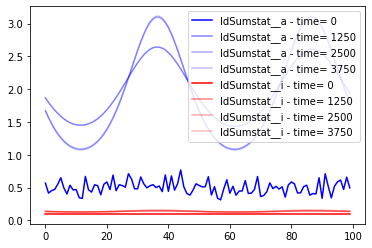

In [8]:
color=['b','r']

color_index=0
size = 100
for key, val in tryjectory.items():
    if key == "loc": continue
    alpha_index = 1
    if key == "IdSumstat__space.x": continue
    for i,time in zip(range (0,int(len(val)),50*size),range(0,4000,50*25)):
        plt.plot(tryjectory["IdSumstat__space.x"][i:i+size], val[i:i+size],label=key +" - time= "+str(time),color=color[color_index],alpha=1/alpha_index)
        alpha_index += 1
    color_index+=1
plt.legend()

Then, we will further define the limits and the scale for parameters space.

In [9]:
limits = {key: (-3,-1) for
          key, val in obs_pars.items()}


In [10]:
model.par_scale="log10"

In [11]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

Now, we will define our objective function:

In [12]:
def eucl_dist(sim, obs):
    total = 0
    for key in sim:
        if key in (
            'loc', "IdSumstat__time", "IdSumstat__space.x"):
                continue
        x = np.array(sim[key])
        y = np.array(obs[key])
        if x.size != y.size:
            return np.inf

        total += np.sum((x - y) ** 2)
    return total


Now, we are ready to start the fitting.

In [13]:
abc = pyabc.ABCSMC(model, prior, eucl_dist, population_size=100)

ABC.Sampler INFO: Parallelize sampling on 12 processes.


In [14]:
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "ActivatorInhibitor_1D.db")
history = abc.new(db_path, dict_data)
history = abc.run(max_nr_populations=8)


ABC.History INFO: Start <ABCSMC id=3, start_time=2021-10-07 11:10:48>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 5.64881376e+04.
ABC INFO: Accepted: 100 / 245 = 4.0816e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.01485257e+04.
ABC INFO: Accepted: 100 / 261 = 3.8314e-01, ESS: 7.9605e+01.
ABC INFO: t: 2, eps: 1.97656927e+04.
ABC INFO: Accepted: 100 / 271 = 3.6900e-01, ESS: 8.0361e+01.
ABC INFO: t: 3, eps: 1.26292621e+04.
ABC INFO: Accepted: 100 / 240 = 4.1667e-01, ESS: 8.9756e+01.
ABC INFO: t: 4, eps: 9.10115053e+03.
ABC INFO: Accepted: 100 / 238 = 4.2017e-01, ESS: 7.9048e+01.
ABC INFO: t: 5, eps: 7.21901839e+03.
ABC INFO: Accepted: 100 / 254 = 3.9370e-01, ESS: 9.5437e+01.
ABC INFO: t: 6, eps: 6.39857696e+03.
ABC INFO: Accepted: 100 / 267 = 3.7453e-01, ESS: 7.6137e+01.
ABC INFO: t: 7, eps: 6.11886369e+03.
ABC INFO: Accepted: 100 / 279 = 3.5842e-01, ESS: 6.5311e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=3, duration=0:01:48.864995, 

Let's now plot the epsilon over different iteration.

In [15]:
pyabc.visualization.plot_epsilons(history)


<AxesSubplot:title={'center':'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

Also, let's plot the kernal density function for our parameters of interest.

array([[<AxesSubplot:ylabel='mu_a'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='mu_i'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu_a', ylabel='rho_a'>,
        <AxesSubplot:xlabel='mu_i'>, <AxesSubplot:xlabel='rho_a'>]],
      dtype=object)

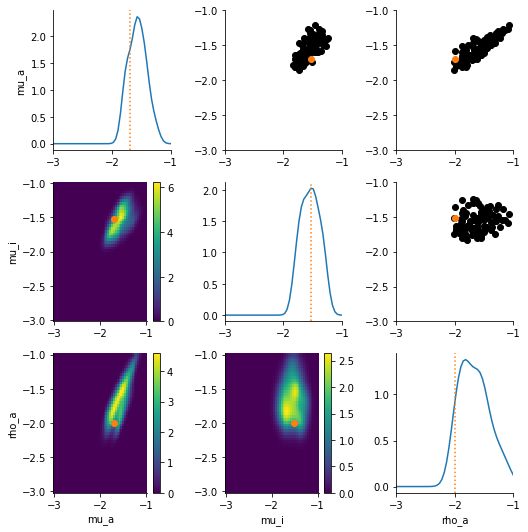

In [16]:
df, w = history.get_distribution(t=history.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=obs_pars_log)

## Define the problem using PEtab extention

Next, we want to fit the same model but now we want to use PEtab format to construct our problem. 

We will start by import a PEtab problem from the yamel file that we already define according to PEtab standared.

In [17]:
petab_problem_path = str((Path(os.getcwd())) / 'PEtab_problem_1' / 'ActivatorInhibitor_1D.yaml')
petab_problem = petab_MS.Problem.from_yaml(petab_problem_path)

In [18]:
importer = PetabImporter(petab_problem)

Then, we will generate all required component from the PEtab problem, such as prior, measurement, parameters' scale, etc.

In [19]:
PEtab_prior = importer.create_prior()

/home/emad/Insync/blackhand.3@gmail.com/Google Drive/Bonn/Github/libpetab-python-MS/petab_MS/parameters.py:375: RuntimeWarning: invalid value encountered in log10
  return np.log10(parameter)


In [20]:
par_map_imported = importer.get_par_map()

In [21]:
obs_pars_imported = petab_problem.get_x_nominal_dict(scaled=True)

In [22]:
PEtab_par_scale = petab_problem.get_optimization_parameter_scales()
obs_pars_imported

{'rho_a': -2.0, 'mu_i': -1.5228787452803376, 'mu_a': -1.6989700043360187}

In [23]:
dict_data_imported = petab_problem.get_measurement_dict()

After that, we will be able to construct our model form the PEtab importer

In [24]:
PEtab_model = importer.create_model()


FitMultiCell.Model INFO: Successfully loaded model


Then, we can modify any of the model's attributes.

In [25]:
PEtab_model.ignore_list=["time", "loc"]


let's now run a simulation tryjectory for the imported PEtab problem.

In [26]:
PEtab_tryjectory = PEtab_model.sample(obs_pars_imported)

Let's now visulise the model tryjectory for both regular and PEtab problem 

In [27]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))


color=['b','r']

    
ax = axes[0]
color_index=0
size = 100
for key, val in PEtab_tryjectory.items():
    if key == "loc": continue
    alpha_index = 1
    if key == "condition1__IdSumstat__space.x": continue
    for i,time in zip(range (0,int(len(val)),50*size),range(0,4000,50*25)):
        ax.plot( PEtab_tryjectory["condition1__IdSumstat__space.x"][i:i+size], val[i:i+size],label=key +" - time= "+str(time),color=color[color_index],alpha=1/alpha_index)
        alpha_index += 1
    color_index+=1
ax.set_title("PEtab problem")

ax = axes[1]
color_index=0
for key, val in tryjectory.items():
    if key == "loc": continue
    alpha_index = 1
    if key == "IdSumstat__space.x": continue
    for i,time in zip(range (0,int(len(val)),50*size),range(0,4000,50*25)):
        ax.plot( tryjectory["IdSumstat__space.x"][i:i+size], val[i:i+size],label=key +" - time= "+str(time),color=color[color_index],alpha=1/alpha_index)
        alpha_index += 1
    color_index+=1
ax.legend()
ax.set_title("Regular problem")


Text(0.5, 1.0, 'Regular problem')

Now, we can go ahead and start the fitting of the PEtab problem.

In [28]:
    abc = pyabc.ABCSMC(PEtab_model, PEtab_prior, eucl_dist, population_size=100)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "PEtab_ActivatorInhibitor_1D.db")
PEtab_history = abc.new(db_path, dict_data_imported)
PEtab_history = abc.run(max_nr_populations=8)


ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2021-10-07 11:12:40>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.96585550e+04.
ABC INFO: Accepted: 100 / 204 = 4.9020e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 3.62914019e+04.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 8.2138e+01.
ABC INFO: t: 2, eps: 2.02558399e+04.
ABC INFO: Accepted: 100 / 236 = 4.2373e-01, ESS: 7.5520e+01.
ABC INFO: t: 3, eps: 1.24498957e+04.
ABC INFO: Accepted: 100 / 297 = 3.3670e-01, ESS: 8.2634e+01.
ABC INFO: t: 4, eps: 8.75288358e+03.
ABC INFO: Accepted: 100 / 289 = 3.4602e-01, ESS: 8.4065e+01.
ABC INFO: t: 5, eps: 6.90568531e+03.
ABC INFO: Accepted: 100 / 305 = 3.2787e-01, ESS: 8.7201e+01.
ABC INFO: t: 6, eps: 6.27022881e+03.
ABC INFO: Accepted: 100 / 250 = 4.0000e-01, ESS: 7.9850e+01.
ABC INFO: t: 7, eps: 6.01376818e+03.
ABC INFO: Accepted: 100 / 353 = 2.8329e-01, ESS: 7.5541e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.Hi

Now, let us compare the regular fitting problem to that that was initialized by PEtab. lets start by plotting the epsilon of the two problems. 

In [29]:
ax= pyabc.visualization.plot_epsilons(PEtab_history, colors=['C1'])
pyabc.visualization.plot_epsilons(history,ax=ax, colors=['C0'])
ax.legend(["PEtab problem","Regular problem"])


Finally, let's plot and compare the final distribution of the two problems. 

In [30]:
fig, axes = plt.subplots(3,1, figsize=(6, 6))
ax =axes[0]
df, w = history.get_distribution(t=history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'mu_a',title="mu_a", refval=obs_pars_log, refval_color='C0', ax=ax)
df, w = PEtab_history.get_distribution(t=PEtab_history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'mu_a', refval_color='C1', ax=ax)
ax.legend(["regular","Ground truth","PEtab"])

ax =axes[1]
df, w = history.get_distribution(t=history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'mu_i', title="mu_i", refval=obs_pars_log, refval_color='C0', ax=ax)
df, w = PEtab_history.get_distribution(t=PEtab_history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'mu_i', refval_color='C1', ax=ax)
ax.legend(["regular","Ground truth","PEtab"])

ax =axes[2]
df, w = history.get_distribution(t=history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'rho_a', title="rho_a", refval=obs_pars_log, refval_color='C0', ax=ax)
df, w = PEtab_history.get_distribution(t=PEtab_history.max_t)
pyabc.visualization.plot_kde_1d(df, w, 'rho_a', refval_color='C1', ax=ax)
ax.legend(["regular","Ground truth","PEtab"])


References:

<sup>1</sup> A. Gierer, H. Meinhardt: A Theory of Biological Pattern Formation. Kybernetik 12: 30-39, 1972.
